In [1]:
%run ../input/python-recipes/dhtml.py
dhtml('Data Processing')

In [2]:
%%writefile load_kaggle_digits.py
import numpy as np,pandas as pd,pylab as pl
from IPython.display import display
def load_kaggle_digits(k,cmap):
    df_train=pd.read_csv(
        '../input/digit-recognizer/train.csv')
    df_test=pd.read_csv(
        '../input/digit-recognizer/test.csv')
    pixel_idx=['%s%s'%('pixel',idx) 
               for idx in range(0,784)]
    train_images=np.array(
        df_train[pixel_idx].values,
                 dtype='float32').reshape(-1,28,28,1)
    train_images=(train_images/255)**k
    test_images=np.array(
        df_test[pixel_idx].values,
                dtype='float32').reshape(-1,28,28,1)
    test_images=(test_images/255)**k
    train_labels=np.array(
        df_train['label'].values,dtype='int32')
    num_classes=len(set(train_labels))
    N=train_labels.shape[0]; n=int(.1*N)
    shuffle_ids=np.arange(N)
    np.random.RandomState(123).shuffle(shuffle_ids)
    train_images=train_images[shuffle_ids]
    train_labels=train_labels[shuffle_ids]
    fig=pl.figure(figsize=(10,6))
    randch=np.random.choice(N,size=15,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(3,5,i+1,xticks=[],yticks=[])
        ax.imshow(train_images[idx].reshape(28,28),
                  cmap=pl.get_cmap(cmap))
        ax.set_title('%d'%train_labels[idx],
                     fontsize=10)
    pl.show()
    x_test,x_valid,x_train=\
    train_images[:n],train_images[n:2*n],train_images[2*n:]
    y_test,y_valid,y_train=\
    train_labels[:n],train_labels[n:2*n],train_labels[2*n:]
    print('function outputs: \n')
    df=pd.DataFrame(
        [[x_train.shape,x_valid.shape,
          x_test.shape,test_images.shape],
         [x_train.dtype,x_valid.dtype,
          x_test.dtype,test_images.dtype],
         [y_train.shape,y_valid.shape,y_test.shape,np.nan],
         [y_train.dtype,y_valid.dtype,y_test.dtype,np.nan]],
        columns=['train','valid','test','global test'],
        index=['image shape','image type',
               'label shape','label type'])
    display(df)
    return x_train,y_train,x_valid,y_valid,\
           x_test,y_test,test_images,num_classes

Writing load_kaggle_digits.py


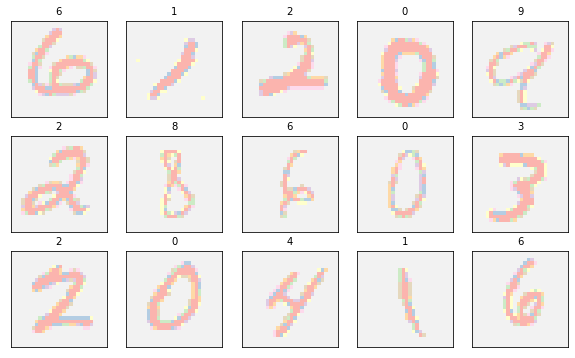

function outputs: 



,train,valid,test,global test
image shape,"(33600, 28, 28, 1)","(4200, 28, 28, 1)","(4200, 28, 28, 1)","(28000, 28, 28, 1)"
image type,float32,float32,float32,float32
label shape,"(33600,)","(4200,)","(4200,)",NaN
label type,int32,int32,int32,NaN


In [3]:
%run load_kaggle_digits.py
k=.75; cmap='Pastel1_r'
x_train,y_train,x_valid,y_valid,x_test,y_test,\
test_images,num_classes=\
load_kaggle_digits(k,cmap)

In [4]:
dhtml('Classification')

In [5]:
%%writefile classify_kaggle_digits.py
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import \
sparse_top_k_categorical_accuracy,\
sparse_categorical_accuracy
from tensorflow.keras.preprocessing.image \
import ImageDataGenerator
from sklearn.metrics import \
classification_report,confusion_matrix
from IPython.display import display
import pandas as pd,pylab as pl

def sparse_top_3_categorical_accuracy(y_true,y_pred):
    return sparse_top_k_categorical_accuracy(y_true,y_pred,k=3)

def cnn_model(num_classes):
    model=Sequential()
    model.add(tkl.Input(shape=(28,28,1)))
    model.add(tkl.BatchNormalization())    
    model.add(tkl.Conv2D(32,(5,5),padding='same'))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.MaxPooling2D(strides=(2,2)))
    model.add(tkl.Dropout(.25))    
    model.add(tkl.Conv2D(96,(5,5)))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.MaxPooling2D(strides=(2,2)))
    model.add(tkl.Dropout(.25)) 
    model.add(tkl.GlobalMaxPooling2D())    
    model.add(tkl.Dense(1024))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.Dropout(.5))    
    model.add(tkl.Dense(num_classes,activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam', 
                  metrics=[sparse_categorical_accuracy,
                           sparse_top_3_categorical_accuracy])    
    return model

def model_callbacks(weights):
    checkpoint=tkc.ModelCheckpoint(
        filepath=weights,verbose=2,save_best_only=True)
    lr_reduce=tkc.ReduceLROnPlateau(
        monitor='val_loss',patience=5,verbose=2,
        factor=.8,min_lr=.1**6)
    estop=tkc.EarlyStopping(
        monitor='val_loss',patience=20,verbose=2)
    return [checkpoint,lr_reduce,estop]

def model_history(cnn_model,weights,epochs,gen_epochs,
                  x_train,y_train,x_valid,y_valid):
    fit_callbacks=model_callbacks(weights)
    train_history=cnn_model.fit(
        x_train,y_train,validation_data=(x_valid,y_valid), 
        epochs=epochs,batch_size=128,verbose=2, 
        callbacks=fit_callbacks) 
    data_generator=ImageDataGenerator(
        zoom_range=.2,shear_range=.2,rotation_range=20,
        width_shift_range=.2,height_shift_range=.2)
    data_generator.fit(x_train)
    generator_history=cnn_model.fit_generator(
        data_generator.flow(x_train,y_train,batch_size=128),
        steps_per_epoch=x_train.shape[0]//128,
        epochs=gen_epochs,verbose=2,
        validation_data=(x_valid,y_valid),
        callbacks=fit_callbacks)
    return train_history,generator_history

def plot_history(model_history,start,color):
    keys=list(model_history.history.keys())
    list_history=[model_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(10,12))
    ax1=fig.add_subplot(411)
    dfkeys.iloc[start:,[0,3]].plot(
        ax=ax1,color=['slategray',color])
    ax2=fig.add_subplot(412)
    dfkeys.iloc[start:,6].plot(ax=ax2,color=color)
    pl.legend()
    ax3=fig.add_subplot(413)
    dfkeys.iloc[start:,[1,4]].plot(
        ax=ax3,color=['slategray',color])
    ax3=fig.add_subplot(414)
    dfkeys.iloc[start:,[2,5]].plot(
        ax=ax3,color=['slategray',color])
    pl.show();
    display(dfkeys.tail(4).T)
    
def model_evaluation(cnn_model,x_test,y_test,
                     weights,color,num_test):
    cnn_model.load_weights(weights)
    y_test_pred=cnn_model.predict_classes(x_test)
    pl.figure(figsize=(10,5))
    pl.scatter(range(num_test),y_test[:num_test],
               s=100,color='slategray')
    pl.scatter(range(num_test),y_test_pred[:num_test],
               s=25,color=color)
    pl.show()
    cnn_scores=cnn_model.evaluate(
        x_test,y_test,verbose=0)
    print('cnn scores: \n',(cnn_scores))
    print('cnn error: %.2f%%'%(100-cnn_scores[1]*100))
    print('classification report: \n')
    print(classification_report(y_test,y_test_pred))
    print('confusion matrix: \n')
    print(confusion_matrix(y_test,y_test_pred))

Writing classify_kaggle_digits.py


In [6]:
%run classify_kaggle_digits.py

<Figure size 432x288 with 0 Axes>

In [7]:
weights='weights.best.hdf5'
epochs=100; gen_epochs=30
cnn_model=cnn_model(num_classes)
train_history,generator_history=\
model_history(cnn_model,weights,epochs,gen_epochs,
              x_train,y_train,x_valid,y_valid)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.12133, saving model to weights.best.hdf5
263/263 - 2s - loss: 0.4846 - sparse_categorical_accuracy: 0.8383 - sparse_top_3_categorical_accuracy: 0.9337 - val_loss: 0.1213 - val_sparse_categorical_accuracy: 0.9757 - val_sparse_top_3_categorical_accuracy: 0.9974
Epoch 2/100

Epoch 00002: val_loss improved from 0.12133 to 0.10808, saving model to weights.best.hdf5
263/263 - 2s - loss: 0.1094 - sparse_categorical_accuracy: 0.9650 - sparse_top_3_categorical_accuracy: 0.9962 - val_loss: 0.1081 - val_sparse_categorical_accuracy: 0.9714 - val_sparse_top_3_categorical_accuracy: 0.9945
Epoch 3/100

Epoch 00003: val_loss improved from 0.10808 to 0.08339, saving model to weights.best.hdf5
263/263 - 2s - loss: 0.0781 - sparse_categorical_accuracy: 0.9757 - sparse_top_3_categorical_accuracy: 0.9978 - val_loss: 0.0834 - val_sparse_categorical_accuracy: 0.9779 - val_sparse_top_3_categorical_accuracy: 0.9974
Epoch 4/100

Epoch 00004: val_loss imp

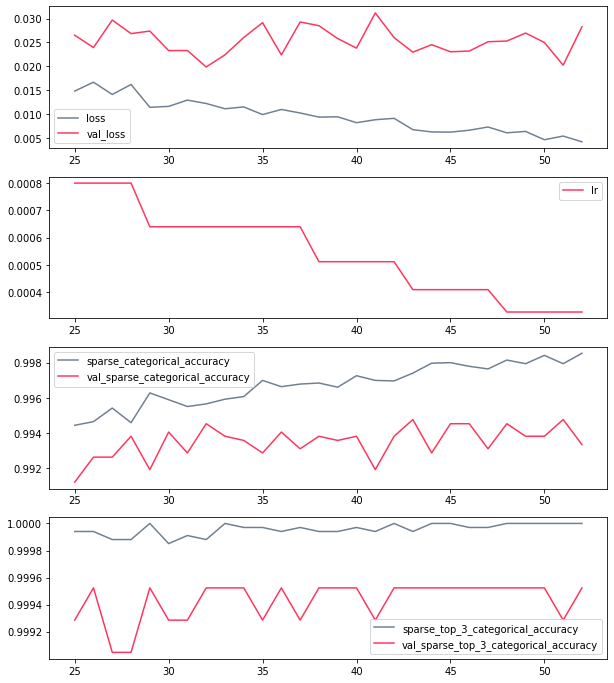

,49,50,51,52
loss,0.006462,0.004723,0.005494,0.004289
sparse_categorical_accuracy,0.997946,0.998423,0.997946,0.998542
sparse_top_3_categorical_accuracy,1.000000,1.000000,1.000000,1.000000
val_loss,0.026964,0.025000,0.020271,0.028280
val_sparse_categorical_accuracy,0.993810,0.993810,0.994762,0.993333
val_sparse_top_3_categorical_accuracy,0.999524,0.999524,0.999286,0.999524
lr,0.000328,0.000328,0.000328,0.000328


In [8]:
color=c1; start=25
plot_history(train_history,start,color)

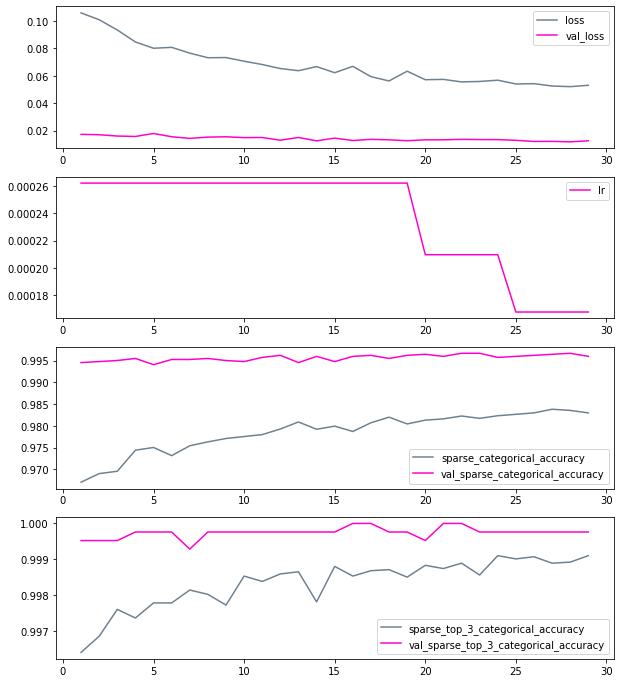

,26,27,28,29
loss,0.054288,0.052582,0.052098,0.053113
sparse_categorical_accuracy,0.982971,0.983807,0.983539,0.982971
sparse_top_3_categorical_accuracy,0.999074,0.998895,0.998924,0.999104
val_loss,0.012082,0.012129,0.011788,0.012566
val_sparse_categorical_accuracy,0.996190,0.996429,0.996667,0.995952
val_sparse_top_3_categorical_accuracy,0.999762,0.999762,0.999762,0.999762
lr,0.000168,0.000168,0.000168,0.000168


In [9]:
color=c10; start=1
plot_history(generator_history,start,color)

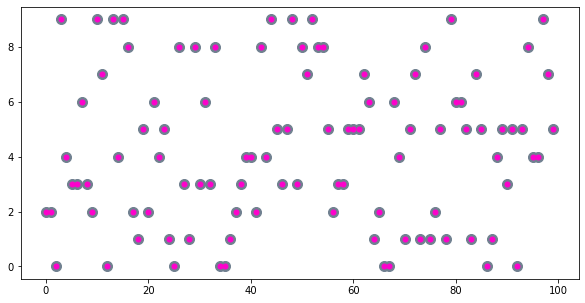

cnn scores: 
 [0.019334981217980385, 0.994523823261261, 0.9995238184928894]
cnn error: 0.55%
classification report: 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       408
           1       1.00      0.99      0.99       469
           2       0.99      1.00      1.00       423
           3       1.00      1.00      1.00       436
           4       0.99      1.00      0.99       410
           5       1.00      0.99      0.99       394
           6       1.00      1.00      1.00       435
           7       0.99      0.99      0.99       423
           8       0.99      1.00      0.99       406
           9       1.00      0.98      0.99       396

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200

confusion matrix: 

[[407   0   0   0   0   0   1   0   0   0]
 [  0 465   1   0   0   0   0   1   2   0]
 [  1   0 422   0

In [10]:
num_test=100
model_evaluation(cnn_model,x_test,y_test,
                 weights,color,num_test)

In [11]:
dhtml('Predictions')

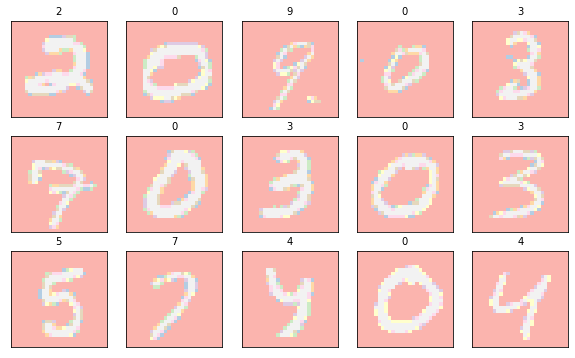

In [12]:
cnn_model.load_weights(weights)
predict_test_labels=\
cnn_model.predict_classes(test_images)
submission=pd.DataFrame(
    {'ImageId':range(1,len(predict_test_labels)+1), 
     'Label':predict_test_labels})
submission.to_csv('kaggle_digits.csv',index=False)
fig=pl.figure(figsize=(10,6))
for i in range(15):
    ax=fig.add_subplot(3,5,i+1,xticks=[],yticks=[])
    ax.imshow(test_images[i].reshape(28,28),
              cmap=pl.get_cmap('Pastel1'))
    ax.set_title('%d'%submission['Label'][i],
                 fontsize=10)
pl.show()